In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_colors
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors


In [2]:
import umap
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from src.file_locations import intermediate_files_location

print(f"sklearn version: {sklearn.__version__}")
print(f"umap version: {umap.__version__}")


sklearn version: 1.7.2
umap version: 0.5.9.post2


In [ ]:
#training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"
training = "first_mixed_del1g_iso_training"

sig_category_name = "del1g_simple_signal_category"

if sig_category_name == "del1g_simple_signal_category":
    sig_categories = del1g_simple_category_labels
    sig_colors = del1g_simple_category_colors
elif sig_category_name == "del1g_detailed_signal_category":
    sig_categories = del1g_detailed_category_labels
    sig_colors = del1g_detailed_category_colors
elif sig_category_name == "topological_signal_category":
    sig_categories = topological_category_labels
    sig_colors = topological_category_colors
else:
    raise ValueError(f"Invalid sig_category_name: {sig_category_name}")


sig_categories: ['1gNp', '1g0p', '1gNp1mu', '1g0p1mu', '1g_outFV', 'NC1pi0_Np', 'NC1pi0_0p', 'numuCC1pi0_Np', 'numuCC1pi0_0p', 'nueCC_Np', 'nueCC_0p', 'multi_pi0', '0pi0', '1pi0_outFV', 'other_outFV', 'dirt', 'ext']
sig_colors: ['xkcd:yellow', 'xkcd:orange', 'xkcd:cyan', 'xkcd:aqua', 'xkcd:pink', 'xkcd:red', 'xkcd:salmon', 'xkcd:ice blue', 'xkcd:azure', 'xkcd:seafoam', 'xkcd:electric green', 'xkcd:blue', 'xkcd:lightblue', 'xkcd:pink', 'xkcd:bright purple', 'xkcd:brown', 'xkcd:green']


# File Loading

In [4]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(2226393, 229)
loading predictions.pkl...
pred_df.shape=(375264, 23)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(187632, 248)
presel_merged_df.shape=(187632, 248)


,wc_single_photon_other_score,wc_shw_sp_n_20mev_showers,wc_numu_score,wc_nue_score,wc_nc_pio_score,wc_single_photon_ncpi0_score,wc_single_photon_nue_score,wc_single_photon_numu_score,wc_shw_sp_n_20br1_showers,wc_nc_delta_score,...,prob_numuCC1pi0_Np,prob_numuCC1pi0_0p,prob_nueCC_Np,prob_nueCC_0p,prob_multi_pi0,prob_0pi0,prob_1pi0_outFV,prob_other_outFV,prob_dirt,prob_ext
7,-2.556328,1.0,-1.043858,-15.000000,-1.320506,0.272143,-1.676819,-2.101542,0.0,-3.831858,...,0.001841,0.001097,0.000811,0.000730,0.000903,0.044337,0.034669,0.061026,0.062698,0.305182
21,-1.135650,2.0,-0.710490,-4.049474,-3.169012,-0.462797,-1.911803,-1.800440,2.0,-2.425649,...,0.003578,0.000705,0.000564,0.000299,0.000599,0.344963,0.001610,0.014333,0.004096,0.066290
60,-0.412643,2.0,3.305738,-12.973451,-2.242356,0.284562,-2.338027,-3.624760,2.0,-7.060031,...,0.019711,0.002417,0.000264,0.000249,0.000324,0.921933,0.000465,0.006013,0.000231,0.001933
71,-1.075697,1.0,1.362073,-9.857704,-3.127084,0.458589,-2.933243,-2.554086,1.0,-7.687320,...,0.011284,0.001299,0.000302,0.000248,0.000696,0.752631,0.000920,0.000801,0.000263,0.002663
83,-3.781686,1.0,0.210693,-9.418540,-3.721158,0.529745,-0.845269,-4.104197,0.0,-7.675740,...,0.001455,0.000711,0.000231,0.000184,0.000260,0.906191,0.001930,0.009288,0.001015,0.013897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226366,NaN,1.0,-0.556400,4.805970,NaN,NaN,NaN,NaN,1.0,NaN,...,0.000333,0.000197,0.000140,0.000126,0.000156,0.001282,0.001270,0.003052,0.001565,0.004572
2226367,NaN,1.0,-0.908498,-4.307141,NaN,NaN,NaN,NaN,1.0,NaN,...,0.000272,0.000105,0.000085,0.000075,0.000093,0.000213,0.000195,0.000143,0.000109,0.000135
2226383,NaN,2.0,-1.074620,-6.602750,NaN,NaN,NaN,NaN,2.0,NaN,...,0.000376,0.000221,0.000173,0.000156,0.000298,0.001126,0.001514,0.000425,0.001144,0.000924
2226390,NaN,1.0,-0.624818,-0.410667,NaN,NaN,NaN,NaN,1.0,NaN,...,0.001025,0.000295,0.005179,0.000288,0.000215,0.000825,0.000267,0.000469,0.000172,0.000470


In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Probability Visualization

In [6]:
#scaler = StandardScaler()
#probs_scaled = scaler.fit_transform(probs_2d_arr)
probs_scaled = probs_2d_arr

reducer = umap.UMAP(random_state=42)

reducer.fit(probs_scaled)
umap_result = reducer.transform(probs_scaled)


/nevis/houston/home/leehagaman/uv_base/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


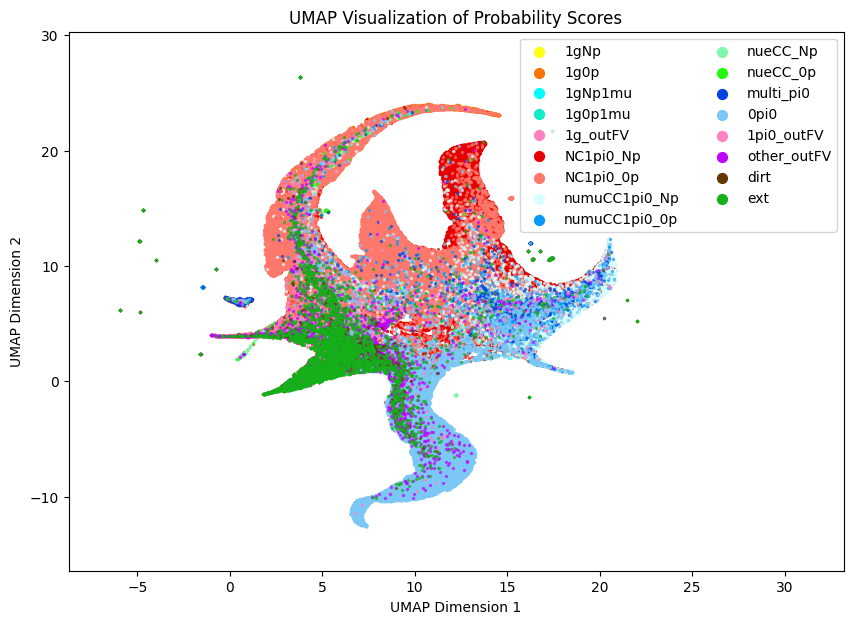

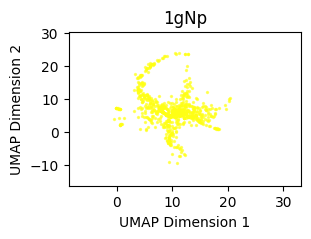

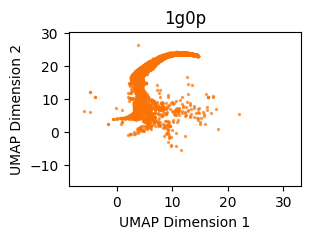

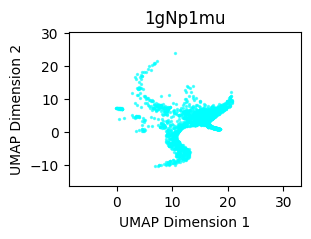

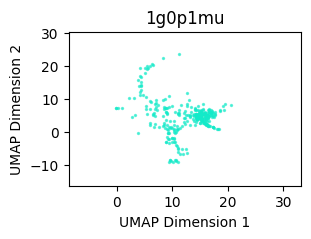

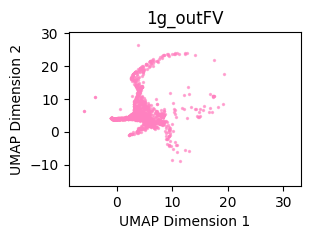

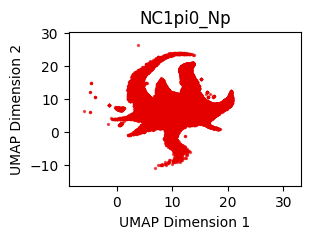

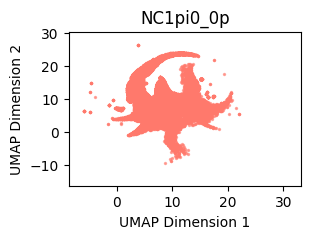

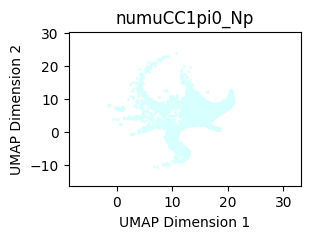

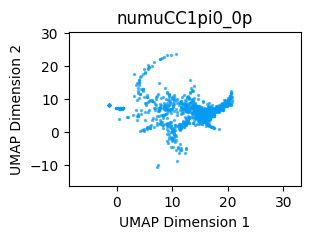

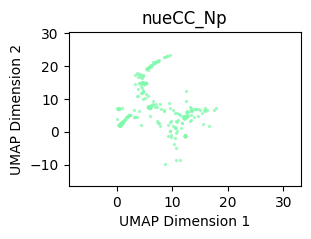

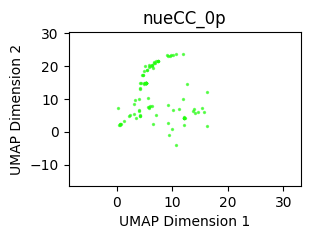

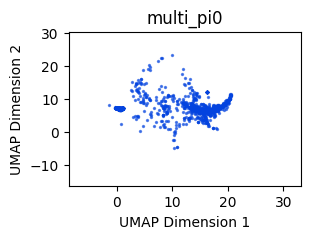

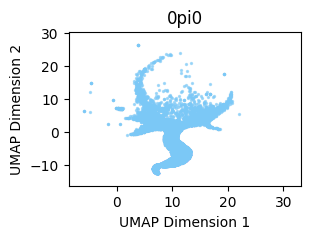

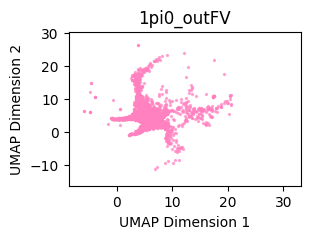

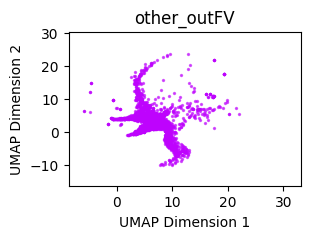

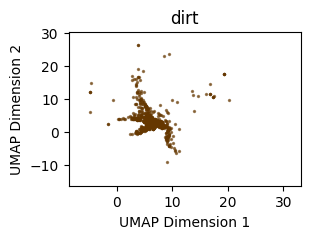

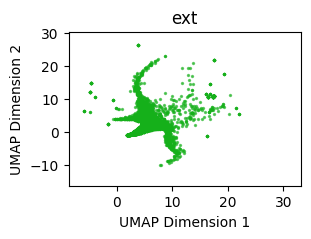

In [7]:
true_sig_categories = presel_merged_df[sig_category_name].to_numpy()
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=sig_colors[i])
    plt.scatter([], [], s=50, c=sig_colors[i], label=sig_categories[i])
plt.title('UMAP Visualization of Probability Scores')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/umap_visualization.png")

for i in range(len(sig_categories)):
    plt.figure(figsize=(3, 2))
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=sig_colors[i])
    plt.scatter([], [], s=50, c=sig_colors[i], label=sig_categories[i])
    plt.title(sig_categories[i])
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
    min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
    x_diff = max_x - min_x
    y_diff = max_y - min_y
    plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
    plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
    plt.savefig(f"../training_outputs/{training}/score_vis/{sig_categories[i]}_umap_visualization.png")
